In [63]:
!pip install transformers --quiet #Hugging Face library → gives us pre-trained NLP models (like BERT, DistilBERT).
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Skipping, found downloaded files in "./news-headlines-dataset-for-sarcasm-detection" (use force=True to force download)


In [64]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel #load tokenizer & pre-trained model.
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Available Device is: ", device)

Available Device is:  cuda


In [66]:
data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace=True)
print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [67]:
data_df = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace=True)
print(f"Dataset shape: {data_df.shape}")
print(f"Class distribution:\n{data_df['is_sarcastic'].value_counts()}")

Dataset shape: (26709, 3)
Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [68]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [69]:
# Check class distribution and calculate weights
print(f"Training class distribution: {np.bincount(y_train)}")
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights}")

Training class distribution: [10469  8227]
Class weights: [0.89292196 1.13625866]


In [70]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  18696  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


In [71]:
#Loads BERT’s tokenizer (turns text → token IDs) and the pre-trained BERT model weights.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

In [72]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float32)
        }

# Create datasets
training_data = SarcasmDataset(X_train, y_train, tokenizer)
validation_data = SarcasmDataset(X_val, y_val, tokenizer)
testing_data = SarcasmDataset(X_test, y_test, tokenizer)

In [73]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 2e-5
MAX_GRAD_NORM = 1.0
PATIENCE = 3

In [74]:
def augment_sarcastic_data(X_train, y_train):
    sarcastic_indices = np.where(y_train == 1)[0]
    # Add variations with different intensifiers
    augmented_texts = []
    augmented_labels = []

    for idx in sarcastic_indices[:100]:  # Take first 100 sarcastic examples
        original_text = X_train[idx]
        # Simple augmentation - add intensifiers
        if "great" in original_text.lower():
            augmented_texts.append(original_text.replace("great", "absolutely fantastic"))
            augmented_labels.append(1)

    return np.concatenate([X_train, augmented_texts]), np.concatenate([y_train, augmented_labels])

# Apply augmentation
X_train_aug, y_train_aug = augment_sarcastic_data(X_train, y_train)
training_data = SarcasmDataset(X_train_aug, y_train_aug, tokenizer)

In [75]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [76]:
class MyModel(nn.Module):
    def __init__(self, bert_model, dropout_rate=0.3):
        super(MyModel, self).__init__()
        self.bert = bert_model
        self.dropout1 = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(768)
        self.linear1 = nn.Linear(768, 384)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.bn2 = nn.BatchNorm1d(384)
        self.linear2 = nn.Linear(384, 128)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.linear3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Get BERT output
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use CLS token representation
        pooled_output = bert_output.last_hidden_state[:, 0]  # CLS token

        # Pass through classifier layers
        x = self.dropout1(pooled_output)
        x = self.bn1(x)
        x = self.relu(self.linear1(x))
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.relu(self.linear2(x))
        x = self.dropout3(x)
        x = self.linear3(x)

        return x.squeeze()


In [77]:
for param in bert_model.parameters():
    param.requires_grad = False
# Unfreeze last 4 layers instead of just 2
for param in bert_model.encoder.layer[-4:].parameters():
    param.requires_grad = True

In [78]:
model = MyModel(bert_model).to(device)


In [79]:
pos_weight = torch.tensor([class_weights[1]/class_weights[0]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam([
    {'params': model.bert.encoder.layer[-2:].parameters(), 'lr': 1e-5},
    {'params': [p for n, p in model.named_parameters() if 'bert' not in n], 'lr': LR}
], weight_decay=1e-5)

In [80]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

In [81]:
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

In [82]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            predictions = model(input_ids, attention_mask)
            loss = criterion(predictions, labels)

            total_loss += loss.item()

            # Collect predictions and labels
            pred_probs = torch.sigmoid(predictions)
            pred_binary = (pred_probs > 0.5).cpu().numpy()
            all_predictions.extend(pred_binary)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return avg_loss, accuracy, f1, all_predictions, all_labels





In [83]:
print("Starting training...")
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0
    train_predictions = []
    train_labels = []

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        predictions = model(input_ids, attention_mask)
        loss = criterion(predictions, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

        optimizer.step()

        total_train_loss += loss.item()

        # Collect predictions for metrics
        pred_probs = torch.sigmoid(predictions)
        pred_binary = (pred_probs > 0.5).cpu().detach().numpy()
        train_predictions.extend(pred_binary)
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_f1 = f1_score(train_labels, train_predictions)

    # Validation phase
    val_loss, val_accuracy, val_f1, _, _ = evaluate_model(model, validation_dataloader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy * 100)
    val_accuracies.append(val_accuracy * 100)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f'Epoch {epoch + 1}/{EPOCHS}:')
    print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, Train F1: {train_f1:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%, Val F1: {val_f1:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f'  New best validation loss: {best_val_loss:.4f}')
    else:
        patience_counter += 1
        print(f'  No improvement. Patience: {patience_counter}/{PATIENCE}')

        if patience_counter >= PATIENCE:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break

    print("=" * 60)
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state for final evaluation.")

# Final test evaluation
test_loss, test_accuracy, test_f1, test_predictions, test_labels = evaluate_model(
    model, testing_dataloader, criterion, device
)


Starting training...
Epoch 1/20:
  Train Loss: 0.5739, Train Acc: 75.21%, Train F1: 0.7452
  Val Loss: 0.3963, Val Acc: 84.70%, Val F1: 0.8245
  New best validation loss: 0.3963
Epoch 2/20:
  Train Loss: 0.3894, Train Acc: 85.19%, Train F1: 0.8371
  Val Loss: 0.3159, Val Acc: 87.72%, Val F1: 0.8593
  New best validation loss: 0.3159
Epoch 3/20:
  Train Loss: 0.3334, Train Acc: 87.35%, Train F1: 0.8596
  Val Loss: 0.2825, Val Acc: 89.14%, Val F1: 0.8780
  New best validation loss: 0.2825
Epoch 4/20:
  Train Loss: 0.2998, Train Acc: 88.98%, Train F1: 0.8775
  Val Loss: 0.2657, Val Acc: 90.39%, Val F1: 0.8897
  New best validation loss: 0.2657
Epoch 5/20:
  Train Loss: 0.2762, Train Acc: 90.14%, Train F1: 0.8897
  Val Loss: 0.2719, Val Acc: 90.81%, Val F1: 0.8924
  No improvement. Patience: 1/3
Epoch 6/20:
  Train Loss: 0.2505, Train Acc: 90.89%, Train F1: 0.8984
  Val Loss: 0.2509, Val Acc: 91.36%, Val F1: 0.9014
  New best validation loss: 0.2509
Epoch 7/20:
  Train Loss: 0.2340, Train 

In [84]:
test_loss, test_accuracy, test_f1, test_predictions, test_labels = evaluate_model(
    model, testing_dataloader, criterion, device
)

In [85]:
print(f"\nFinal Test Results:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions,
                          target_names=['Non-Sarcastic', 'Sarcastic']))


Final Test Results:
Test Accuracy: 91.29%
Test F1-Score: 0.8997
Test Loss: 0.2660

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.92      0.93      0.92      2256
    Sarcastic       0.91      0.89      0.90      1751

     accuracy                           0.91      4007
    macro avg       0.91      0.91      0.91      4007
 weighted avg       0.91      0.91      0.91      4007



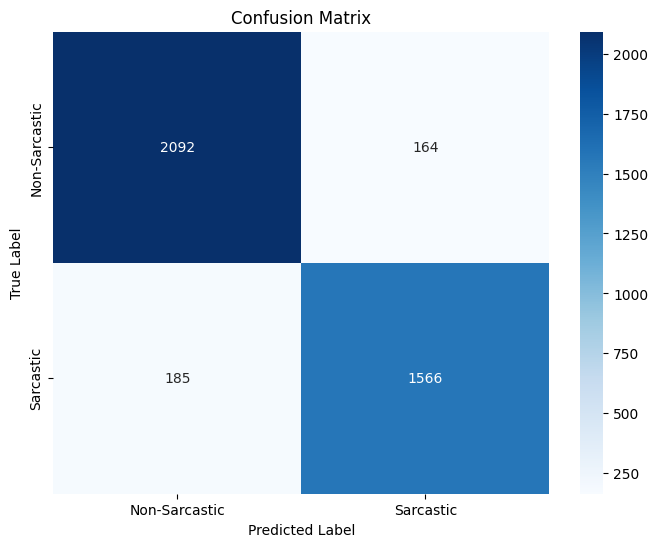

In [86]:
import seaborn as sns

cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Sarcastic', 'Sarcastic'],
            yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

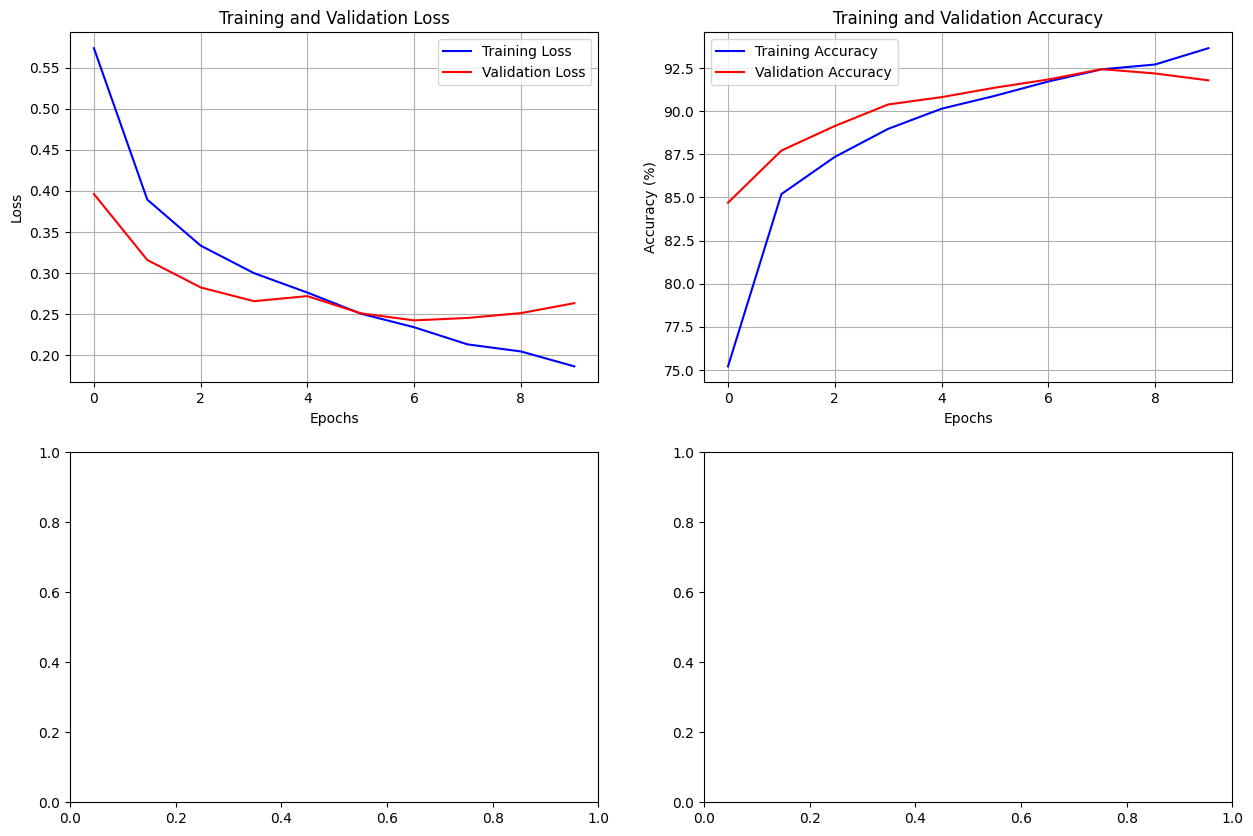

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Loss plots
axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy plots
axes[0, 1].plot(train_accuracies, label='Training Accuracy', color='blue')
axes[0, 1].plot(val_accuracies, label='Validation Accuracy', color='red')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)

In [88]:
# F1 Score plots
axes[1, 0].plot(train_f1_scores, label='Training F1', color='blue')
axes[1, 0].plot(val_f1_scores, label='Validation F1', color='red')
axes[1, 0].set_title('Training and Validation F1-Score')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

In [89]:
axes[1, 1].bar(['Training', 'Validation', 'Test'],
               [train_accuracies[-1], val_accuracies[-1], test_accuracy*100])
axes[1, 1].set_title('Final Accuracy Comparison')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [91]:
def predict_sarcasm(text, model, tokenizer, device, max_length=96):
    model.eval()
    encoding = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        logits = model(input_ids, attention_mask)
        probability = torch.sigmoid(logits).item()

        return probability, "Sarcastic" if probability > 0.4 else "Non-Sarcastic"

# Example predictions
sample_texts = [
    "This is the best day ever!",  # Ambiguous - could be genuine
    "Oh great, another meeting about meetings",  # Clear sarcasm
    "I love spending my entire weekend working",  # Clear sarcasm
    "I absolutely love getting stuck in traffic for hours",  # Clear sarcasm
    "The weather is beautiful today",  # Likely genuine
    "Perfect, my computer crashed right before the deadline",  # Clear sarcasm
    "What a fantastic way to start Monday morning",  # Likely sarcasm
    "Thank you so much for the helpful feedback"  # Ambiguous context-dependent
]

print("\nSample Predictions:")
for text in sample_texts:
    prob, label = predict_sarcasm(text, model, tokenizer, device)
    print(f"Text: '{text}'")
    print(f"Prediction: {label} (Probability: {prob:.4f})")
    print("-" * 50)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    predictions_thresh = (torch.tensor([0.0037, 0.8451, 0.0115, 0.0042]) > threshold).int()
    print(f"Threshold {threshold}: {predictions_thresh.tolist()}")


Sample Predictions:
Text: 'This is the best day ever!'
Prediction: Non-Sarcastic (Probability: 0.0022)
--------------------------------------------------
Text: 'Oh great, another meeting about meetings'
Prediction: Sarcastic (Probability: 0.5105)
--------------------------------------------------
Text: 'I love spending my entire weekend working'
Prediction: Non-Sarcastic (Probability: 0.0044)
--------------------------------------------------
Text: 'I absolutely love getting stuck in traffic for hours'
Prediction: Non-Sarcastic (Probability: 0.0033)
--------------------------------------------------
Text: 'The weather is beautiful today'
Prediction: Non-Sarcastic (Probability: 0.0016)
--------------------------------------------------
Text: 'Perfect, my computer crashed right before the deadline'
Prediction: Non-Sarcastic (Probability: 0.0296)
--------------------------------------------------
Text: 'What a fantastic way to start Monday morning'
Prediction: Non-Sarcastic (Probability: